### Imports

In [1]:
import numpy as np
import bond_pricing

### Day Count Convention

The relevant time period in most financial markets is based on the number of days between the starting and ending dates. In other words, “parking lot rules”(whereby both the starting and ending dates count) do not apply.

In [2]:
from datetime import date
from pandas import to_datetime, Timedelta, DateOffset
from importlib import import_module

daycount_dict = {'actual/360': 'actual360', 
                 'actual/365': 'actual365',
                 'actual/actual': 'actualactual', 
                 'thirty/360': 'thirty360'}

settle = to_datetime('2024-1-12')
mat = to_datetime('2024-03-12')
convention = 'actual/365'

In [3]:
def days_year(settle, mat, convention='actual/360'):
    name = 'isda_daycounters.'+ daycount_dict[convention]
    days = import_module(name).day_count(settle, mat)
    if convention == "actual/360" or convention == "thirty/360":
      year = 360
    elif convention == "actual/365":
      year = 365
    else:
      oneyear = settle + DateOffset(years=1)
      year = (oneyear - settle).days
    return days, year
    
days, year = days_year(settle, mat, convention=convention)
print(f'{days = }\n{year = }')

days = 60
year = 365


In [4]:
def year_frac(settle, mat, convention='actual/360', inverse=False):
    name = 'isda_daycounters.'+ daycount_dict[convention]
    fraction = import_module(name).year_fraction(settle, mat)
    if inverse:
      return fraction
    else:
      return 1/fraction

dayYear = year_frac(settle, mat, convention=convention, inverse=False)
print(f'{dayYear = }')
print(year/days)

yearDay = year_frac(settle, mat, convention=convention, inverse=True)
print(f'{yearDay = }')
print(days/year)

dayYear = 6.083333333333334
6.083333333333333
yearDay = 0.1643835616438356
0.1643835616438356


### Add-On Rate

The following rates are generally quoted on an add-on rate basis:
- Commercial bank loans and deposits
- Certificates of deposit (CD)
- Repos
- Fed funds
- LIBOR
- SOFR
- Commercial paper (CP) in Euromarkets

Add-on rates follow a simple interest calculations. The **interest is added on to the principal amount** to get the **redemption payment** at maturity.

$$FV=PV+\left[PV \times AOR \times \frac{Days}{Year}\right]$$
$$FV=PV\times\left[1 + \left(AOR \times \frac{Days}{Year}\right)\right]$$
$$\frac{FV}{PV}=\left[1 + \left(AOR \times \frac{Days}{Year}\right)\right]$$
$$PV=\frac{FV}{\left[1 + \left(AOR \times \frac{Days}{Year}\right)\right]}$$
$$AOR=\left(\frac{Year}{Days}\right)\times\left(\frac{FV-PV}{PV}\right)$$
$$AOR\times\left(\frac{Days}{Year}\right)=\left(\frac{FV-PV}{PV}\right)$$

- AOR is the quoted add-on rate (annual percentage rate (APR))
- PV the present value (the initial principal amount)
- FV the future value (the redemption payment including interest)
- Days the number of days until maturity, and 
- Year the number of days in the year

In [5]:
def addon_fv(pv, aor, days, year=360):
    return pv * (1 + (aor * days  / year))

pv = 1_000_000
aor = 0.039
days = 180
year = 360

fv = addon_fv(pv, aor, days, year)
print(f'fv ={round(fv, 2): ,}')
periodicity = year/days
print(f'{periodicity = }')

fv = 1,019,500.0
periodicity = 2.0


In [6]:
def addon_pv(fv, aor, days, year=360):
    return fv / (1 + (aor * days  / year))

fv = 1_019_500
aor = 0.0372
days = 120
year = 360

pv = addon_pv(fv, aor, days, year)
print(f'pv ={round(pv, 2): ,}')
periodicity = year/days
print(f'{periodicity = }')

pv = 1,007,013.04
periodicity = 3.0


In [7]:
def addon_rate(pv, fv, days, year=360):
    return (year/days) * (fv - pv)/pv

pv = 1_000_000
fv = 1_007_013.04
days = 60
year = 360

aor = addon_rate(pv, fv, days, year)
print(f'{aor = : 0.4f}')
periodicity = year/days
print(f'{periodicity = }')

aor =  0.0421
periodicity = 6.0


In [8]:
def periodicity(days, year):
    return year / days

days = 90
year = 360

print(periodicity(days, year))

4.0


### Discount Rate

The following rates are generally quoted on a discount rate basis:
- T-Bills
- Commercial paper (CP) 
- Banker's acceptance

The price of the security is a **discount from the face value**. The future (or face) value times the annual discount rate times the fraction of the year. Interest is not “added on” to the principal; instead it is included in the face value.

$$PV = FV - \left[FV \times DR \times \frac{Days}{Year}\right]$$
$$PV = FV \times \left[1 - \left(DR \times \frac{Days}{Year}\right)\right]$$
$$\frac{PV}{FV} = \left[1 - \left(DR \times \frac{Days}{Year}\right)\right]$$
$$FV = \frac{PV}{\left[1 - \left(DR \times \frac{Days}{Year}\right)\right]}$$
$$DR=\left(\frac{Year}{Days}\right)\times\left(\frac{FV-PV}{FV}\right)$$
$$DR\times\left(\frac{Days}{Year}\right)=\left(\frac{FV-PV}{FV}\right)$$

- DR is the discount rate
- PV the present value (the initial principal amount)
- FV the future value (the redemption payment including interest)
- Days the number of days until maturity, and 
- Year the number of days in the year

The “amount” of a transaction is the face value (the FV) for instruments quoted on a discount rate basis. In contrast, the “amount” is the original principal (the PV at issuance) for money market securities quoted on an add-on rate basis.

Note:
$$PV = FV - \left[FV \times DR \times \frac{Days}{Year}\right]$$
Can be simplified to:
$$PV = FV - \text{Dollar Discount}$$
where $\text{Dollar Discount} = FV  \times DR \times \frac{Days}{Year}$

In [9]:
def dr_pv(fv, dr, days, year=360):
    return fv * (1 - (dr * days  / year))

fv = 1_000_000
dr = 0.038
days = 180
year = 360

pv = dr_pv(fv, dr, days, year)
print(f'pv ={round(pv, 2): ,}')
periodicity = year/days
print(f'{periodicity = }')

pv = 981,000.0
periodicity = 2.0


In [10]:
def dr_pv(fv, dr, days, year=360):
    return fv * (1 - (dr * days  / year))

fv = 1_000_000
dr = 0.0335
days = 30
year = 360

pv = dr_pv(fv, dr, days, year)
print(f'pv ={round(pv, 2): ,}')
periodicity = year/days
print(f'{periodicity = }')

pv = 997,208.33
periodicity = 12.0


In [11]:
def dr_fv(pv, dr, days, year=360):
    return pv / (1 - (dr * days  / year))

pv = 1_019_500
dr = 0.0372
days = 120
year = 360

fv = dr_fv(pv, dr, days, year)
print(f'fv ={round(fv, 2): ,}')

fv = 1,032,300.53


In [12]:
def dr_rate(pv, fv, days, year=360):
    return (year/days) * (fv - pv)/fv

pv = 1_007_013
fv = 1_019_500
days = 120
year = 360

dr = dr_rate(pv, fv, days, year)
print(f'{dr = : 0.4f}')

dr =  0.0367


### Comparing Discount Rate and Add-on Rate

General conversion formula between discount rates and addon rates (and vice versa) when quoted for the **same assumed number of days in the year**:

$$AOR = \frac{Year \times DR}{Year - (Days \times DR)}$$
$$DR = \frac{Year \times AOR}{Year + (Days \times AOR)}$$

Note that the DR, unlike an AOR, is **not an APR** because the $\frac{FV - PV}{FV}$ is not the periodic interest rate, it is the interest earned relative to the future value. This is not the way we think about an interest rate — the growth rate of an investment should be measured by the increase in value (FV − PV) given where we start (PV), not where we end (FV). The discount rate systematically understate the investor’s rate of return, as well as the borrower’s cost of funds. AOR will always be greater than the DR for the same cash flows, the more so the greater the number of days in the time period and the higher the level of interest rates.

In [13]:
def equiv_rate(rate, days, year, aor=True):
    if aor:
        return (year * rate) / (year - (days * rate))
    else:
        return (year * rate) / (year + (days * rate))
    

dr = 0.038
days = 180
year = 360

aor = equiv_rate(dr, days, year, aor=True)
print(f'{aor = }')

dr = equiv_rate(aor, days, year, aor=False)
print(f'{dr = }')

aor = 0.03873598369011213
dr = 0.038


### Converting Between Rate Periodicity 

Converting between discrete periodicities:
$$\Big(1+\frac{APR_{m}}{m}\Big)^{m} = \Big(1+\frac{APR_{n}}{n}\Big)^{n}$$
$$n\times\Big[\Big(1+\frac{APR_{m}}{m}\Big)^{m/n}-1\Big] = APR_{n}$$

In [14]:
quoted_apr = 0.04
m = 360/180
n = 1

print(bond_pricing.equiv_rate(rate=quoted_apr, from_freq=m, to_freq=n))

0.04039999999999999


### Bond Equivalent Yield (BEY) or Investment Rate (IR)

The intent of *bond equivalent yield* (BEY) is to report to investors an interest rate for the security that is more meaningful than the discount rate and that allows a comparison to Treasury note and bond yields.

A **bond equivalent yield** (BEY) is a money market rate stated on a **365-day add-on rate basis**. 

$$BEY=\left(\frac{365}{Days}\right)\times\left(\frac{FV-PV}{PV}\right)$$
$$BEY=\left(\frac{365}{Days}\right)\times\left(\frac{\text{Dollar Discount}}{PV}\right)$$
$$BEY=\left(\frac{365}{Days}\right)\times\left(\frac{FV  \times DR \times \frac{Days}{Year}}{PV}\right)$$
$$BEY = \frac{365 \times DR}{Year_{\text{DR Convention}} - (Days \times DR)}$$

The U.S. Treasury uses a different method to calculate its official Investment Rate (i.e., the bond equivalent yield) when the time to **maturity exceeds six months**. The BEY for the 52-week T-bill is based on the following formula:

$$BEY=\frac{-\frac{2\times Days}{365} + 2 \times \sqrt{\left(\frac{Days}{365}\right)^{2}-\left(\frac{2\times Days}{365}-1\right)\left(1-\frac{100}{PV}\right)}}{\frac{2\times Days}{365}-1}$$

derived from:
$$100=PV\times \left(1+\frac{182.5}{365}\times BEY\right)\times \left(1+\frac{Days - 182.5}{365}\times BEY\right)$$

| Term    | Maturity Date | Discount Rate | Investment Rate | Price (per $100 in par value) |
| ------- | ------------- | ------------- | --------------- | ----------------------------- |
| 4 week  | 31/07/2008    | 1.850%         | 1.878%           | 99.856111                      |
| 13 week | 02/10/2008    | 1.900%         | 1.936%           | 99.519722                      |
| 26 week | 02/01/2009    | 2.135%         | 2.188%           | 98.914708                      |
| 52 week | 03/07/2009    | 2.295%         | 2.368%           | 97.679500                       |

In [15]:
settle = to_datetime("2008-7-3")
convention = 'actual/360'
mat_dr = {'2008-7-31': 0.0185,
             '2008-10-2': 0.019,
             '2009-1-2': 0.02135,
             '2009-7-3': 0.02295}

days_pv = {}
for mat, dr in mat_dr.items():
    days, year = days_year(settle, to_datetime(mat), convention=convention)
    price = dr_pv(100, dr, days, year)
    days_pv[days] = price
    bey = (365 * dr) / (360 - (days * dr)) # DR to BEY conversion formula
    print(f'{price = :0.5f}, {days = }, {bey = :0.5f}')
    
print()

for days, price in days_pv.items():
    bey = addon_rate(price, 100, days, year=365) # AOR Cash flow formula set to 365 year
    print(f'{bey = :0.5f}')

price = 99.85611, days = 28, bey = 0.01878
price = 99.51972, days = 91, bey = 0.01936
price = 98.91471, days = 183, bey = 0.02188
price = 97.67312, days = 365, bey = 0.02382

bey = 0.01878
bey = 0.01936
bey = 0.02188
bey = 0.02382


In [16]:
def bey_short(rate, days, year, from_dr_rate=True):
    if from_dr_rate:
        return (365 * rate) / (year - (days * rate))
    else:
        premium = rate * (days/year) 
        return (365 / days) * premium 
    
days = 91
year = 360
rate = 0.019
from_dr_rate = False

bey_short(rate, days, year, from_dr_rate)

0.019263888888888886

In [17]:
def bey_long(days, pv):
    D = (2*days)/365
    num = -D + 2 * ((days/365)**2 - (D - 1) * (1 - (100/pv)))**(1/2)
    return num / (D - 1)

days = 364
pv = 97.6795

bey_long(days, pv)

0.02368170792870403

### Semiannual Bond Basis (SABB)

For comparability of Treasury securities such as bills, notes, and bonds across maturities, it is often advisable to convert rates to semiannual compounding because that is how yields to maturity on Treasury notes and bonds are calculated and presented. T-bill discount rates can be first converted to a **365-day add-on** basis and then converted to a **semiannual bond basis (SABB)**.

Note that $SABB = APR_{2}$

Step 1:
$$BEY = \frac{365 \times DR}{Year_{\text{DR}} - (Days \times DR)}$$
Step 2:
$$\left(1+\frac{BEY}{Year/Days}\right)^{Year/Days} = \Big(1+\frac{SABB}{2}\Big)^{2}$$
$$2\times\left[\left(1+\frac{BEY}{Year/Days}\right)^{(Year/Days)/2}-1\right] = SABB$$

In [18]:
def sabb(rate, days, year, from_dr_rate=True):
    bey = bey_short(rate, days, year, from_dr_rate)
    year_frac = year/days
    return 2 * ((1 + bey/year_frac)**(year_frac/2) - 1)

In [19]:
mat_dr = {'2008-7-31': 0.0185,
             '2008-10-2': 0.019,
             '2009-1-2': 0.02135,
             '2009-7-3': 0.02295}

convention = 'actual/360'

for mat, dr in mat_dr.items():
    days, year = days_year(settle, to_datetime(mat), convention=convention)
    bey = bey_short(dr, days, year) if days < 183 else bey_long(days, dr_pv(100, dr, days, year))
    semiannual = sabb(dr, days, year)
    print(f'{semiannual = :0.5f}, {bey = :0.5f}, {days = }')

semiannual = 0.01886, bey = 0.01878, days = 28
semiannual = 0.01940, bey = 0.01936, days = 91
semiannual = 0.02188, bey = 0.02188, days = 183
semiannual = 0.02368, bey = 0.02368, days = 365


### Examples

Suppose that a money market security can be purchased on January 12 for $64,000. The security matures on March 12, paying $65,000. Calculate the interest rate on the security to the nearest one-tenth of a basis point, given the following quotation methods and day-count conventions:
- Add-on Rate, Actual/360
- Add-on Rate, Actual/365
- Add-on Rate, 30/360
- Add-on Rate, Actual/370
- Discount Rate, Actual/360

In [20]:
pv = 64_000
fv = 65_000
settle = to_datetime('2025-1-12')
mat = to_datetime('2025-3-12')
convention = 'actual/360'

days, year = days_year(settle, mat, convention)
print(f'{days = }\n{year = }')
aor = addon_rate(pv, fv, days, year)
print(f'{aor = : 0.5f}')

days = 59
year = 360
aor =  0.09534


In [21]:
pv = 64_000
fv = 65_000
settle = to_datetime('2025-1-12')
mat = to_datetime('2025-3-12')
convention = 'actual/365'

days, year = days_year(settle, mat, convention)
print(f'{days = }\n{year = }')
aor = addon_rate(pv, fv, days, year)
print(f'{aor = : 0.5f}')

days = 59
year = 365
aor =  0.09666


In [22]:
pv = 64_000
fv = 65_000
settle = to_datetime('2025-1-12')
mat = to_datetime('2025-3-12')
convention = 'thirty/360'

days, year = days_year(settle, mat, convention)
print(f'{days = }\n{year = }')
aor = addon_rate(pv, fv, days, year)
print(f'{aor = : 0.5f}')

days = 60
year = 360
aor =  0.09375


In [23]:
pv = 64_000
fv = 65_000
settle = to_datetime('2025-1-12')
mat = to_datetime('2025-3-12')
convention = 'thirty/360'

days = days_year(settle, mat, convention)[0]
year = 370
print(f'{days = }\n{year = }')
aor = addon_rate(pv, fv, days, year)
print(f'{aor = : 0.5f}')

days = 60
year = 370
aor =  0.09635


In [24]:
pv = 64_000
fv = 65_000
settle = to_datetime('2025-1-12')
mat = to_datetime('2025-3-12')
convention = 'actual/360'

days, year = days_year(settle, mat, convention)
print(f'{days = }\n{year = }')
dr = dr_rate(pv, fv, days, year)
print(f'{dr = : 0.5f}')

days = 59
year = 360
dr =  0.09387


Suppose that sometime in the not-so-distant future the fastest-growing financial institution in the world is **Bank 24/7/52**. Its success owes to pioneering use of hourly interest rates for loans and deposits, an idea borrowed from the success of the hourly car rental businesses. Its (add-on) rates on short term large time deposits (>$1,000,000) are shown in table below. The APR quoted by Bank 24/7/52 assumes a 364-day year. For instance, 3.4944% is calculated as 0.0004% * 24 * 7 * 52.

To see how hourly interest rates might work, suppose a corporation makes a 52-hour, $5,000,000 time deposit at Bank 24/7/52. The redemption amount on the deposit can be calculated using an hourly version of the below equation. The corporation will receive $5,001,560 when the deposit
matures.

$$FV=PV\times\left[1 + \left(AOR \times \frac{Days}{Year}\right)\right]$$

| Time Period | Rate per Hour | APR     |
| ----------- | ------------- | ------- |
| 1–8 Hours   | 0.0004%       | 3.4944% |
| 9–24 Hours  | 0.0005%       | 4.3680% |
| 25–72 Hours | 0.0006%       | 5.2416% |

In [25]:
rate_per_hour = [4e-6, 5e-6, 6e-6]
apr = [rate_per_hour[i] * 24 * 7 * 52 * 100 for i in range(len(rate_per_hour))]
print(apr)

pv = 5_000_000
hours = 52
days = hours/24
year = 364

fv = round(addon_fv(pv, apr[2]/100, days, year)) 
print(f'{fv = :_}')

[3.4944, 4.368000000000001, 5.2416]
fv = 5_001_560


Now suppose that 30 hours after making the time deposit, the corporation has sudden need for liquidity. Bank 24/7/52’s policy is to buy back time deposits as a service to its regular corporate customers. The redemption amount is fixed once the deposit is issued. The present value of the time deposit after 30 hours have passed and 22 hours remain is computed using the equation used earlier.


In [26]:
sold_hour = 22
sold_days = sold_hour/24

pv_sold = round(addon_pv(fv, aor=apr[1]/100, days=sold_days, year=year))
print(f'{pv_sold = :_}')

pv_sold = 5_001_010


How did the corporation do on its short-term investment? The realized rate of return for its 30-hour holding period can be calculated with an hourly version of the equation below. That turns out to be 5.8822% on a 364-day add-on basis.

$$AOR=\left(\frac{Year}{Days}\right)\times\left(\frac{FV-PV}{PV}\right)$$

In [27]:
hours_held = 30
days_held = hours_held/24

aor = addon_rate(pv, pv_sold, days_held, year)*100
print(f'{aor = }')
periodicity = year/days_held
print(f'{periodicity = }')

aor = 5.8822399999999995
periodicity = 291.2


Suppose that, for consistency, the money manager likes to convert all rates of return to a semiannual bond basis. Equation below can be used to convert that AOR to an SABB, but first one additional step is needed.

$$2\times\left[\left(1+\frac{BEY}{Year/Days}\right)^{(Year/Days)/2}-1\right] = SABB$$

In general, interest rates should be put on a full-year, 365-day basis before carrying out the periodicity conversion. That is because an SABB having a periodicity of 2 implicitly assumes two evenly spaced periods in the 365-day year, each period having 182.5 days. (Notice that this assumption is implicit in equation below)

$$100=PV\times \left(1+\frac{182.5}{365}\times BEY\right)\times \left(1+\frac{Days - 182.5}{365}\times BEY\right)$$

So, first we need to convert 5.8822% to an addon rate for 365 days in the year by multiplying by 365/364.

$$AOR_{start}=\left(\frac{Year_{start}}{Days}\right)\times\left(\frac{FV-PV}{PV}\right)$$
$$\left(\frac{365}{Year_{start}}\right)\times AOR_{start}=\left(\frac{\cancel{Year_{start}}}{Days}\right)\times\left(\frac{FV-PV}{PV}\right)\times \left(\frac{365}{\cancel{Year_{start}}}\right)$$
$$AOR_{365}=\left(\frac{365}{Year_{start}}\right)\times AOR_{start}$$

In [28]:
year_new = 365
aor_365 = (year_new/year) * aor
print(aor_365)
periodicity_new = year_new/days_held
print(f'{periodicity_new = }')

5.8984
periodicity_new = 292.0


This rate is now an APR for 292 periods in the year: (365 * 24)/30 = 292. The holding-period rate of return converted to an SABB is 5.9856%.

In [29]:
semiannual = sabb(aor_365/100, days_held, year_new, from_dr_rate=False)

print(semiannual*100)

5.985625711839848


https://www.youtube.com/watch?v=ufO_BScIHDQ

### Compare Rates - Plot

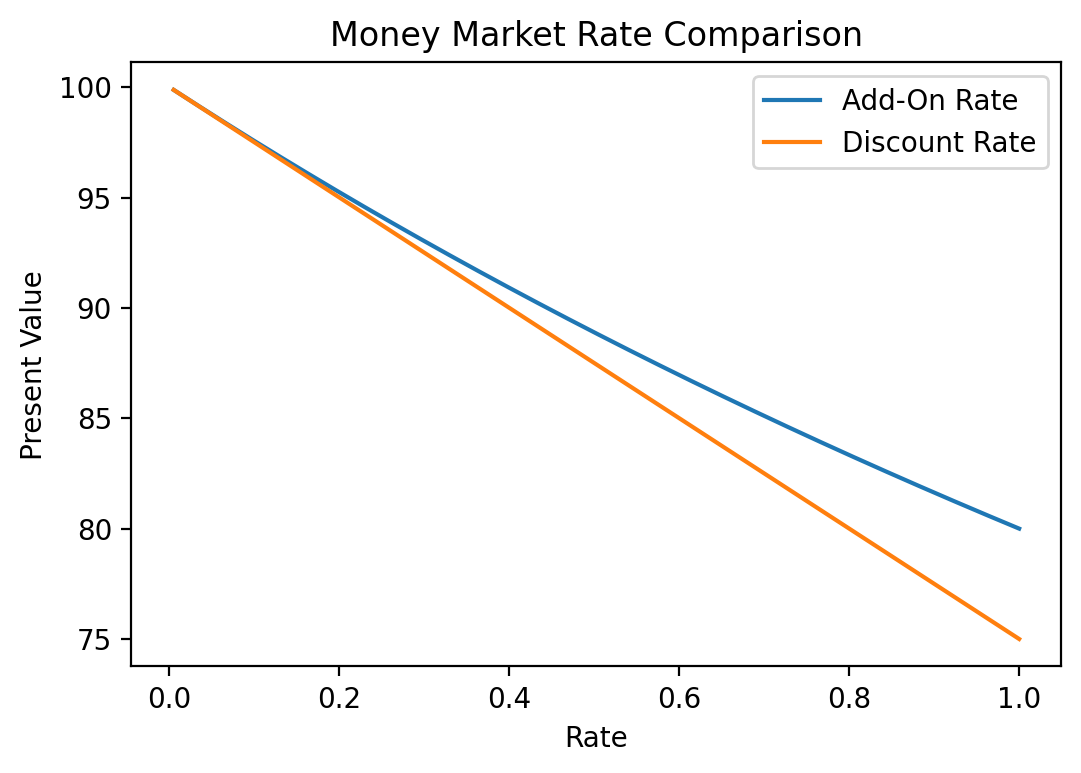

In [30]:
import matplotlib.pyplot as plt

fv = 100
days = 90
year = 360

rate_x = np.linspace(0.005, 1, num=1000)
addon_price_y = addon_pv(100, rate_x, days, year)
dr_price_y = dr_pv(100, rate_x, days, year)

plt.figure(num=0, dpi=200)
plt.plot(rate_x, addon_price_y, label="Add-On Rate")
plt.plot(rate_x, dr_price_y, label="Discount Rate")
plt.title('Money Market Rate Comparison')
plt.xlabel('Rate')
plt.ylabel('Present Value')
plt.legend()